# KBL 승부예측 - 1. Binary Classfication Models

In [ ]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
RANDOM_SEED = 2022

## 10게임 데이터 전처리

In [ ]:
# Colab google drive mount 경로

df_10game = pd.read_csv('/content/drive/MyDrive/KBL Prediction/dataset/recent_avg_record_10game.csv')

In [ ]:
# win 컬럼 생성, 이기면 1 지면 0
df_10game['win'] = df_10game['score'] - df_10game['loss']
df_10game.loc[df_10game['score'] > df_10game['loss'], 'win'] = 1
df_10game.loc[df_10game['score'] < df_10game['loss'], 'win'] = 0

In [ ]:
# X, y 분리
X = df_10game.iloc[:, 5:-1]
X.drop(columns=['ef','maxContiScoreCn', 'maxLeadScoreCn', 'playMin', 'playSec', 'scoreHighTimeCn', 'inout', 'inout1', 'idf', 'fb'], inplace=True)
y = df_10game.iloc[:,-1]

In [ ]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)

In [ ]:
# Standard Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_train_scaled

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

## 1. Random Forest
- Grid Search로 hyper parameter 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [200, 250],
    'max_depth': [7, 8],
    'min_samples_leaf': [6, 7],
    'min_samples_split': [2],
    'n_jobs': [-1],
    'random_state': [RANDOM_SEED]
}

model = RandomForestClassifier()
grid = GridSearchCV(model, param, refit=True, verbose=2)

In [ ]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=2022; total time=   2.5s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=2022; total time=   1.4s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=2022; total time=   1.5s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=2022; total time=   1.4s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=2022; total time=   1.4s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=250, n_jobs=-1, random_state=2022; total time=   1.8s
[CV] END max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=250, n_jobs=-1, random_state=2022; total time=   2.8s
[CV] END max_depth=7, min_samp

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 8], 'min_samples_leaf': [6, 7],
                         'min_samples_split': [2], 'n_estimators': [200, 250],
                         'n_jobs': [-1], 'random_state': [2022]},
             verbose=2)

In [ ]:
print("Best avg score : ", grid.best_score_)
print("Best params : ", grid.best_params_)

Best avg score :  0.587878982415065
Best params :  {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 250, 'n_jobs': -1, 'random_state': 2022}


Feature importance 시각화

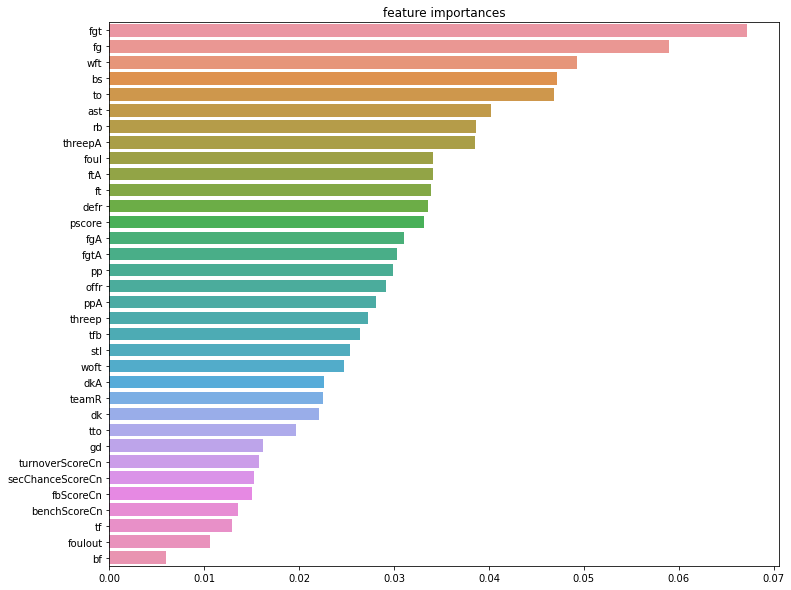

In [ ]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=X_train_scaled.columns)
ft_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y=ft_importances.index)
plt.show()

## 2. Gradient Boosting
- Grid Search로 hyper parameter 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param = {
    'learning_rate': [0.03, 0.05, 0.07, 0.09],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [6, 7, 8],
    'max_depth': [3, 5, 7, 9],
    'random_state': [RANDOM_SEED]
}

model = GradientBoostingClassifier()
grid = GridSearchCV(model, param, refit=True, verbose=2)

In [ ]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=100, random_state=2022; total time=   2.5s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=100, random_state=2022; total time=   2.5s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=100, random_state=2022; total time=   2.5s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=100, random_state=2022; total time=   2.5s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=100, random_state=2022; total time=   2.6s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=200, random_state=2022; total time=   4.9s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=200, random_state=2022; total time=   5.3s
[CV] END learning_rate=0.03, max_depth=3, min_samples_leaf=6, n_estimators=200, random_state=2022; total time= 

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.03, 0.05, 0.07, 0.09],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [6, 7, 8],
                         'n_estimators': [100, 200, 300],
                         'random_state': [2022]},
             verbose=2)

In [ ]:
print("Best avg score : ", grid.best_score_)
print("Best params : ", grid.best_params_)

Best avg score :  0.5913692836373249
Best params :  {'learning_rate': 0.07, 'max_depth': 3, 'min_samples_leaf': 8, 'n_estimators': 100, 'random_state': 2022}


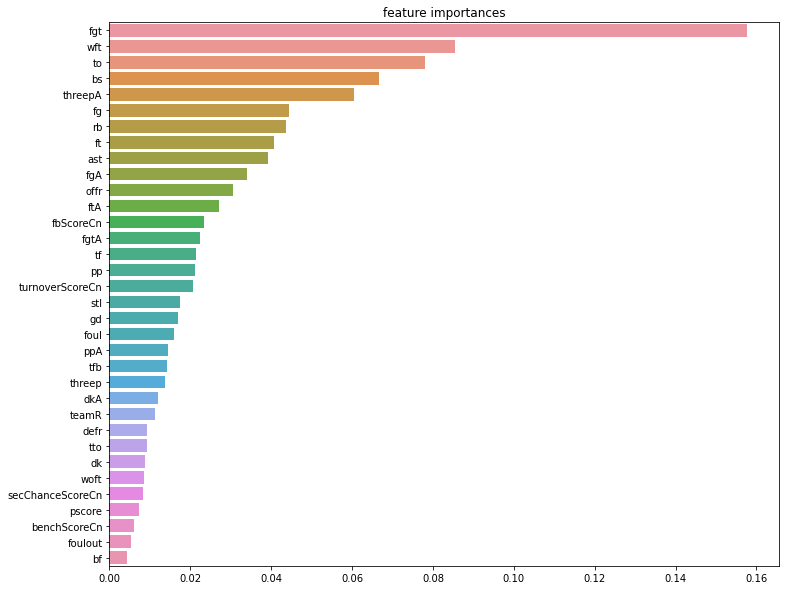

In [ ]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=X_train_scaled.columns)
ft_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y=ft_importances.index)
plt.show()

## 3. AdaBoost
- Grid Search로 hyper parameter 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

param = {
    'learning_rate': [0.05, 0.07, 0.09],
    'n_estimators': [100, 200, 300],
    'random_state': [RANDOM_SEED]
}

model = AdaBoostClassifier()
grid = GridSearchCV(model, param, refit=True, verbose=2)

In [ ]:
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   1.9s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   1.6s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   1.2s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   1.5s
[CV] END learning_rate=0.05, n_estimators=100, random_state=2022; total time=   1.7s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   3.0s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   2.9s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   3.3s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   2.4s
[CV] END learning_rate=0.05, n_estimators=200, random_state=2022; total time=   2.4s
[CV] END learning_rate=0.05, n_estimators=300, random_state=2022; total time=   3.7s
[CV] 

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.05, 0.07, 0.09],
                         'n_estimators': [100, 200, 300],
                         'random_state': [2022]},
             verbose=2)

In [ ]:
print("Best avg score : ", grid.best_score_)
print("Best params : ", grid.best_params_)

Best avg score :  0.5823284619160908
Best params :  {'learning_rate': 0.05, 'n_estimators': 300, 'random_state': 2022}


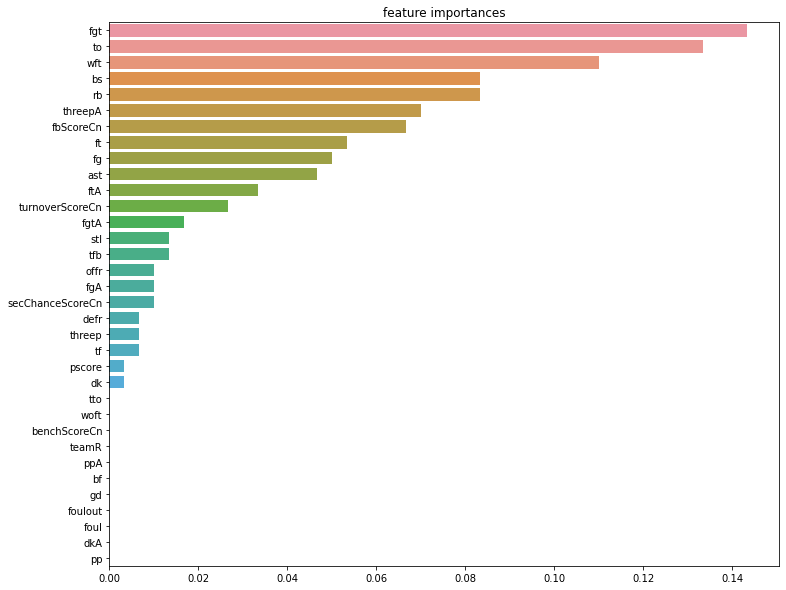

In [ ]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

ft_importances = pd.Series(feature_importances, index=X_train_scaled.columns)
ft_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y=ft_importances.index)
plt.show()